In [218]:
from IPython.utils import io
import os
import subprocess
import tqdm.notebook



TQDM_BAR_FORMAT = '{l_bar}{bar}| {n_fmt}/{total_fmt} [elapsed: {elapsed} remaining: {remaining}]'

In [219]:
from botorch import fit_gpytorch_model
from botorch.models import SingleTaskGP
from gpytorch.mlls import ExactMarginalLogLikelihood
from gpytorch.kernels import RBFKernel, ScaleKernel
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import torch
from botorch.acquisition import ExpectedImprovement
from botorch.optim import optimize_acqf
from collections import Counter
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
from IPython.display import clear_output
import time

Global optimum value: -2.9486837251832947
Location: x=1.1616161616161618, y=-4.494949494949495


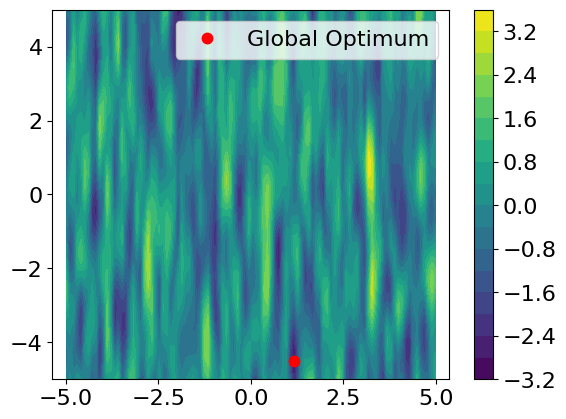

In [220]:
# グローバルで関数の形状を決定
N = 100
grid_points = np.linspace(-5, 5, N)
kernel = RBF(length_scale=[0.1, 1.0])
gpr = GaussianProcessRegressor(kernel=kernel)
X, Y = np.meshgrid(grid_points, grid_points)
XY = np.array([X.ravel(), Y.ravel()]).T
y = gpr.sample_y(XY, random_state=42).reshape(X.shape)

global_optimum = y.min()

# 最小値のインデックスを取得
min_idx = y.argmin()
j, i = np.unravel_index(min_idx, y.shape)

# 対応する座標を取得
x_opt = grid_points[i]
y_opt = grid_points[j]

print(f"Global optimum value: {global_optimum}")
print(f"Location: x={x_opt}, y={y_opt}")

plt.contourf(X, Y, y, levels=20)
plt.colorbar()
plt.plot(x_opt, y_opt, 'r.', markersize=15, label='Global Optimum')  # 赤い点を追加
plt.legend()  # 凡例を表示
plt.axis("equal")
plt.show()

In [221]:
def objective_function(x):
    # グリッド上の最も近い点を見つける
    if torch.is_tensor(x):
        x = x.numpy()
    
    x1, x2 = x[..., 0], x[..., 1]
    
    # バッチ処理に対応
    if isinstance(x1, np.ndarray):
        # 複数の入力点がある場合
        result = []
        for k in range(len(x1)):
            i = np.abs(grid_points - x1[k]).argmin()
            j = np.abs(grid_points - x2[k]).argmin()
            result.append(y[j, i])
        return torch.tensor(result, dtype=torch.float32)
    else:
        # 単一の入力点の場合
        i = np.abs(grid_points - x1).argmin()
        j = np.abs(grid_points - x2).argmin()
        return torch.tensor([y[j, i]], dtype=torch.float32)

In [222]:
class ECI_BO_Bandit:
    def __init__(self, X, objective_function, bounds, n_initial, n_max, dim, gamma=0.99):
        self.objective_function = objective_function
        self.bounds = bounds  # Should be a list of tensors: [lower_bounds, upper_bounds]
        self.n_initial = n_initial
        self.n_max = n_max
        self.dim = dim
        self.X = X
        self.Y = None
        self.best_value = None
        self.best_point = None
        self.model = None
        self.gamma = 1

        # Bandit algorithm parameters
        self.dimension_counts = [1] * self.dim  # Number of times each dimension was selected
        self.dimension_rewards = [0.0] * self.dim  # Cumulative rewards for each dimension
        self.squared_reward = [0.0] * self.dim  # Cumulative squared rewards for each dimension

        self.eval_history = [self.best_value] * n_initial
        self.arm_selection_history = []
        self.optimization_history = [] 

    def update_model(self):
        kernel = ScaleKernel(RBFKernel(ard_num_dims=self.X.shape[-1]), noise_constraint=1e-5)
        self.model = SingleTaskGP(self.X, self.Y, covar_module=kernel)
        mll = ExactMarginalLogLikelihood(self.model.likelihood, self.model)
        fit_gpytorch_model(mll)

    def normalize_rewards(self, rewards):
        if isinstance(rewards, (int, float)):
            return rewards  # 単一の値の場合はそのまま返す
        min_reward = min(rewards)
        max_reward = max(rewards)
        if min_reward == max_reward:
            return [1.0] * len(rewards)
        return [(r - min_reward) / (max_reward - min_reward) for r in rewards]

    def initialize(self):
        self.Y = self.objective_function(self.X).unsqueeze(-1)
        self.best_value = self.Y.min().item()
        self.best_point = self.X[self.Y.argmin()]
        self.update_model()
        self.eval_history = [self.best_value] * self.n_initial

        # Calculate initial ECI values and normalize them
        eci_values = self.calculate_eci()
        self.dimension_rewards = self.normalize_rewards(eci_values)
        self.squared_reward = [r ** 2 for r in self.dimension_rewards]

    def select_dimension(self, total_iterations):
        sorted_indices = sorted(range(self.dim), key=lambda k: self.dimension_rewards[k], reverse=True)
        for i in sorted_indices:
            if self.dimension_counts[i] == 1:
                # Ensure each dimension is selected at least once
                return i
        # UCB calculation
        ucb_values = []
        for i in range(self.dim):
            average_reward = self.dimension_rewards[i] / self.dimension_counts[i]
            var = max(0, self.squared_reward[i] / self.dimension_counts[i] - average_reward ** 2)
            confidence = math.sqrt(2 * var * math.log(total_iterations + 1) / self.dimension_counts[i]) + 3 * math.log(
                total_iterations + 1) / self.dimension_counts[i]
            ucb = average_reward + confidence
            ucb_values.append(ucb)
        # Select dimension with highest UCB
        return ucb_values.index(max(ucb_values))

    def calculate_eci(self):
        eci_values = []
        for i in range(self.dim):
            ei = ExpectedImprovement(self.model, best_f=self.best_value, maximize=False)

            def eci_func(x):
                # x has shape [batch_size, q=1, d=1]
                batch_size = x.shape[0]
                full_x = self.best_point.clone().unsqueeze(0).expand(batch_size, -1).clone()
                full_x[:, i] = x.view(-1)
                full_x = full_x.unsqueeze(1)  # shape [batch_size, q=1, dim]
                return ei(full_x)

            bound = torch.tensor([[self.bounds[0][i]], [self.bounds[1][i]]], device=self.X.device)
            candidate, value = optimize_acqf(
                eci_func, bound, q=1, num_restarts=10, raw_samples=100,
            )
            eci_values.append(value.item())
        return eci_values

    def optimize(self):
        self.initialize()
        self.optimization_history = []
        n = self.n_initial
        total_iterations = 1  # For UCB calculation

        while n < self.n_max:
            self.update_model()
            print(f"Iteration {n}, reward: {self.dimension_rewards}")

            # Select a dimension to optimize using the bandit algorithm
            selected_dim = self.select_dimension(total_iterations)
            self.arm_selection_history.append(selected_dim)
            print(f"Selected dimension: {selected_dim}")

            # Optimize over the selected dimension
            ei = ExpectedImprovement(self.model, best_f=self.best_value, maximize=False)

            def eci_func(x):
                batch_size = x.shape[0]
                full_x = self.best_point.clone().unsqueeze(0).expand(batch_size, -1).clone()
                full_x[:, selected_dim] = x.view(-1)
                full_x = full_x.unsqueeze(1)
                return ei(full_x)

            # Bounds for the selected dimension
            bounds = torch.tensor([
                [self.bounds[0][selected_dim]],
                [self.bounds[1][selected_dim]]
            ], device=self.X.device)

            # Optimize the acquisition function over the selected dimension
            candidate, acq_value = optimize_acqf(
                eci_func,
                bounds,
                q=1,
                num_restarts=10,
                raw_samples=100,
            )

            # Construct the new point
            new_x = self.best_point.clone()
            new_x[selected_dim] = candidate.squeeze()
            new_y = self.objective_function(new_x.unsqueeze(0)).unsqueeze(-1)

            # Update data
            self.X = torch.cat([self.X, new_x.unsqueeze(0)])
            self.Y = torch.cat([self.Y, new_y])
            
            self.optimization_history.append(new_x.clone())

            improvement = max(0, self.best_value - new_y.item())
            if improvement == 0:
                improvement = 0
            else:
                improvement = 1

            self.dimension_rewards = self.gamma * torch.tensor(self.dimension_rewards)
            self.dimension_rewards[selected_dim] += improvement
            self.squared_reward = self.gamma * torch.tensor(self.squared_reward)
            self.squared_reward[selected_dim] += improvement ** 2

            # Update best value and point if improvement is found
            if new_y.item() < self.best_value:
                self.best_value = new_y.item()
                self.best_point = new_x

            self.eval_history.append(self.best_value)

            # Update bandit statistics
            self.dimension_counts = self.gamma * torch.tensor(self.dimension_counts)
            self.dimension_counts[selected_dim] += 1

            n += 1
            total_iterations += 1
            print(f"Iteration {n}, Best value: {self.best_value} ")

        return self.best_point, self.best_value

In [223]:
def generate_initial_points(n_initial, dim, bounds):
    return torch.rand(n_initial, dim) * (bounds[1] - bounds[0]) + bounds[0]

In [224]:
dim = 2
active_dim = 1
bounds = torch.tensor([[-5.0] * dim, [5.0] * dim])
n_initial = 100
n_iter = 500
n_runs = 20

In [225]:
eci_bo_bandit_history = []
arm_selection_history = []

In [226]:
try:
  with tqdm.notebook.tqdm(total=100, bar_format=TQDM_BAR_FORMAT) as pbar:
    with io.capture_output() as captured:
      for run in range(n_runs):
        X = generate_initial_points(n_initial, dim, bounds)
        eci_bo_bandit = ECI_BO_Bandit(X, objective_function, bounds, n_initial, n_iter, dim)
        best_x, best_f = eci_bo_bandit.optimize()
        eci_bo_bandit_history.append(eci_bo_bandit.eval_history)
        arm_selection_history.append(eci_bo_bandit.arm_selection_history)  
        pbar.update(100 / n_runs) 
      eci_bo_bandit_history_average = np.mean(eci_bo_bandit_history, axis=0)  
except subprocess.CalledProcessError:
  print(captured)
  raise

  0%|          | 0/100 [elapsed: 00:00 remaining: ?]

In [227]:
def plot_optimization_trajectory():
    plt.figure(figsize=(15, 5))
    
    # 収束プロット
    plt.subplot(1, 2, 1)
    plt.plot(eci_bo_bandit_history_average)
    plt.axhline(y=global_optimum, color='r', linestyle='--', label='Global Optimum')
    plt.xlabel('Iteration')
    plt.ylabel('Best Value Found')
    plt.legend()
    plt.title('Convergence Plot')

    # 探索の軌跡プロット
    plt.subplot(1, 2, 2)
    x_grid, y_grid = np.meshgrid(grid_points, grid_points)
    plt.contourf(x_grid, y_grid, y, levels=20)
    plt.colorbar()
    plt.plot(x_opt, y_opt, 'r*', markersize=15, label='True Optimum')
    
    # 探索点の軌跡を描画
    if len(eci_bo_bandit.optimization_history) > 0:
        points = torch.stack(eci_bo_bandit.optimization_history).detach().numpy()
        for i in range(len(points)):
            alpha = (i + 1) / len(points)  # 点の透明度を時間とともに変化
            plt.plot(points[i, 0], points[i, 1], 'wo', alpha=alpha, markersize=5)
    
    plt.axis('equal')
    plt.legend()
    plt.title('Optimization Trajectory')
    
    plt.tight_layout()
    plt.show()

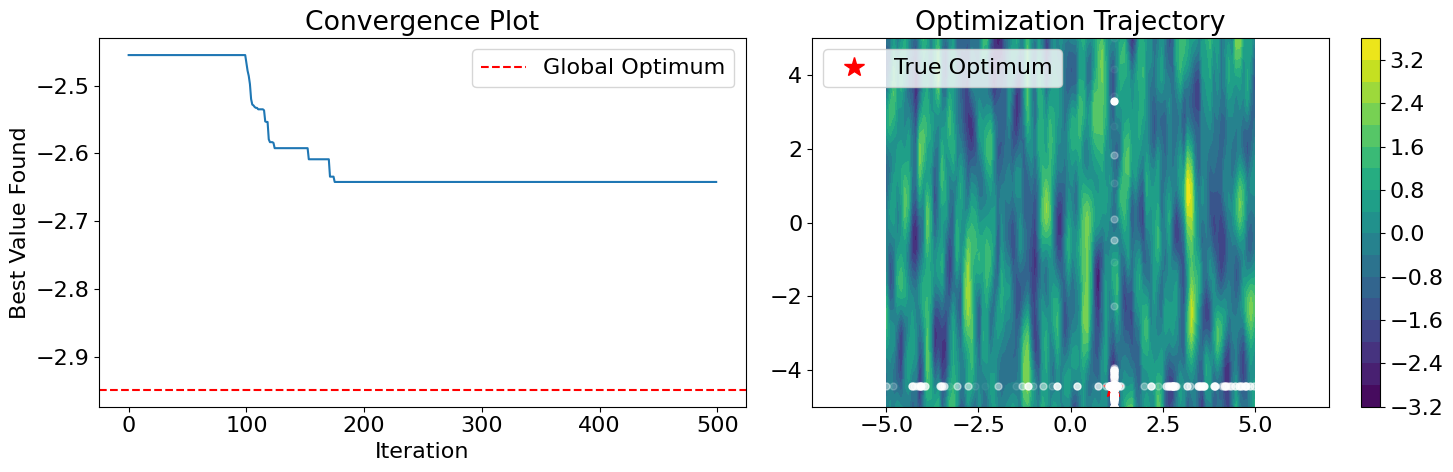

In [228]:
plot_optimization_trajectory()

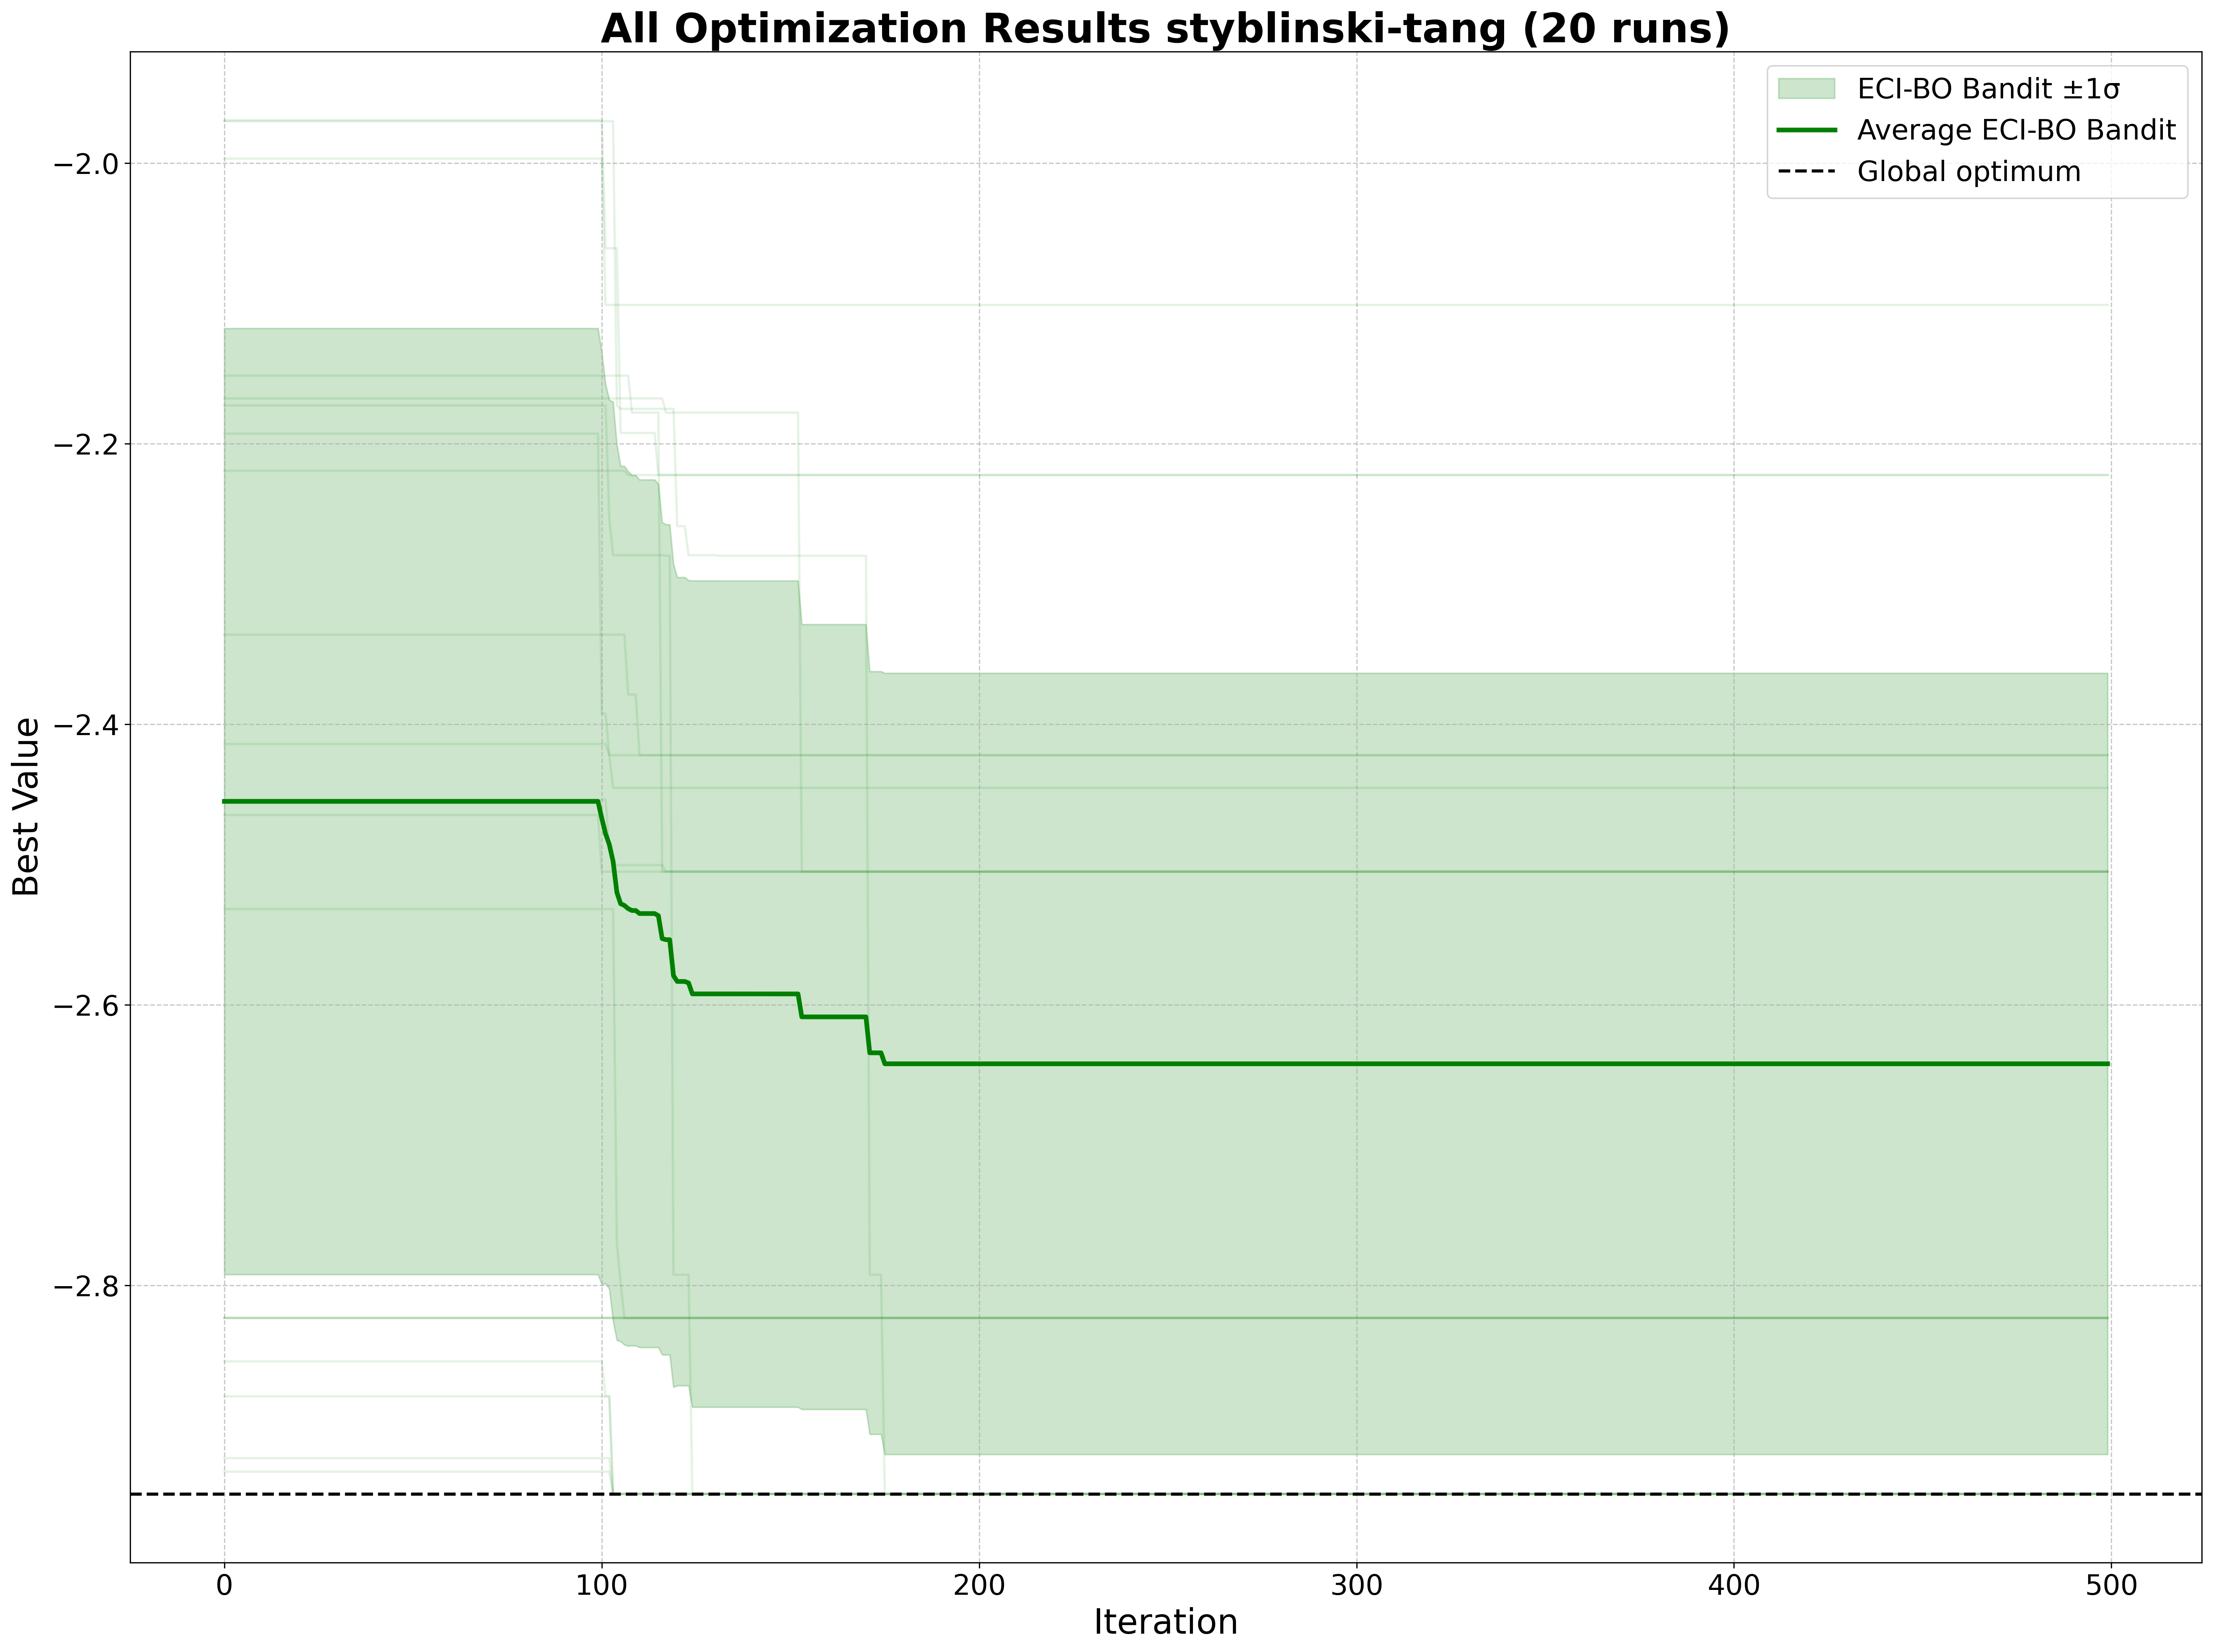

In [229]:
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 15), dpi=300)
plt.rcParams.update({'font.size': 16})

# Calculate mean and standard deviation for each method
def calculate_confidence_bands(histories):
    histories_array = np.array(histories)
    mean = np.mean(histories_array, axis=0)
    std = np.std(histories_array, axis=0)
    return mean, mean - std, mean + std

# ECI-BO Bandit
mean_bandit, lower_bandit, upper_bandit = calculate_confidence_bands(eci_bo_bandit_history)
# Plot individual runs
for history in eci_bo_bandit_history:
    plt.plot(history, color='green', alpha=0.1)
# Plot confidence band and mean
plt.fill_between(range(len(mean_bandit)), lower_bandit, upper_bandit,
                 color='green', alpha=0.2, label='ECI-BO Bandit ±1σ')
plt.plot(mean_bandit, label="Average ECI-BO Bandit", color='green', linewidth=3)

# Global optimum line
plt.axhline(global_optimum, color="black", linestyle="--", label="Global optimum", linewidth=2)

# Customize plot
plt.xlabel("Iteration", fontsize=22)
plt.ylabel("Best Value", fontsize=22)
plt.title(f"All Optimization Results styblinski-tang ({n_runs} runs)", fontsize=26, fontweight='bold')
plt.legend(fontsize=18, loc='upper right')
plt.grid(True, linestyle='--', alpha=0.7)

plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

plt.tight_layout()

# Save the plot
plt.savefig('optimization_results_complete.png', dpi=300, bbox_inches='tight')